OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.



Tester les modèles suivants : **regression linéaire (avec différentes régularisation : Ridge, Lasso, Elastic), Random Forest, XGboost**
Penser à comparer les performances des différents modèles : utiliser la **MAE** ( Mean Absolute Error)
Penser également à optimiser les hyper paramètres de chaque modèle via **GridSearch**


Evaluate :

https://cloud.google.com/automl-tables/docs/evaluate?hl=fr


KFOLD

Entrée : données X (dimension nxp), étiquettes y (dimension n), nombre de folds k

Couper [0, 1, ..., n-1] en k parties de taille (n/k). (La dernière partie sera un peu plus petite si n n'est pas un multiple de k)

for i=0 to (k-1):
    Former le jeu de test (X_test, y_test) en restreignant X et y aux indices contenus dans la i-ième partie.
    Former le jeu d'entraînement (X_train, y_train) en restreignant X et y aux autres indices.
    Entraîner l'algorithme sur le jeu d'entraînement
    Utiliser le modèle ainsi obtenu pour prédire sur le jeu de test
        Calculer l'erreur du modèle en comparant les étiquettes prédites aux vraies étiquettes contenues dans y_test

Sortie : la valeur moyenne des erreurs calculées sur les k folds.

In [178]:
# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire

### Introduction

#### Importing libraries

In [179]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [180]:
from functions import *
from evaluate import *

In [181]:
import warnings
warnings.filterwarnings(action="ignore")

In [182]:
# Set random integer (seed) - 891
from random import randrange
#seed = randrange(1000)
seed = 1
print("Seed value: ", seed)

Seed value:  1


#### Loading dataset

In [183]:
train = pd.read_csv(r"C:\Users\oumei\Documents\OC_projets\P4\P4_Data_Science_OpenClassrooms\other_documents\Example\output\train_energy.csv", sep=",")
test = pd.read_csv(r"C:\Users\oumei\Documents\OC_projets\P4\P4_Data_Science_OpenClassrooms\other_documents\Example\output\test_energy.csv", sep=",")


In [184]:
display(train)

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SteamUse(kBtu),Log-Electricity(kBtu),Log-NaturalGas(kBtu),Log-TotalEnergy(kBtu)
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,-0.00339,0.42943,1.72317,-0.41882,1.41137,2.69150,0.00000,14.40498,14.39644,15.09387
1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.00339,0.10365,-0.86133,-0.41882,-0.93683,-0.43363,0.00000,14.25581,3.52636,14.25583
2,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.00339,0.42943,2.00033,2.62824,1.38926,3.01148,0.00000,16.48056,15.39767,16.77219
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,-0.00339,-0.80911,-0.29193,1.92390,-0.93683,-0.43363,0.00000,11.58826,13.93443,14.02585
4,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.00339,0.10365,-0.51549,-0.41882,0.85599,-0.43363,0.00000,13.75901,13.01555,14.14798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.00339,-0.29507,0.23384,-0.41882,0.84251,-0.43363,0.00000,14.16893,0.00000,14.16893
2198,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.00339,0.42943,-0.42621,-0.41882,-0.93683,-0.43363,0.00000,14.11789,0.00000,14.11789
2199,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.00339,0.94347,0.93009,-0.41882,1.25240,-0.43363,0.00000,14.96780,14.45114,15.43562
2200,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.00339,-0.29507,-0.77146,-0.41882,0.87418,2.26429,13.12387,13.25725,14.24925,14.77715


In [185]:
X_train = train.iloc[:, :-4] # all rows, 51 columns (not last five)
X_test = test.iloc[:, :-4]

y_train = train["Log-Electricity(kBtu)"]
y_test = test["Log-Electricity(kBtu)"]

In [186]:
X_train

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearBuilt,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.37103,-0.00339,0.42943,1.72317,-0.41882,1.41137,2.69150
1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,-0.48760,-0.00339,0.10365,-0.86133,-0.41882,-0.93683,-0.43363
2,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.95134,-0.00339,0.42943,2.00033,2.62824,1.38926,3.01148
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.32181,-0.00339,-0.80911,-0.29193,1.92390,-0.93683,-0.43363
4,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.71152,-0.00339,0.10365,-0.51549,-0.41882,0.85599,-0.43363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.47170,-0.00339,-0.29507,0.23384,-0.41882,0.84251,-0.43363
2198,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.50167,-0.00339,0.42943,-0.42621,-0.41882,-0.93683,-0.43363
2199,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.31108,-0.00339,0.94347,0.93009,-0.41882,1.25240,-0.43363
2200,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,-2.04645,-0.00339,-0.29507,-0.77146,-0.41882,0.87418,2.26429


In [187]:
# predict : Electricity
# train / test
# standardisation = retirer la moyen et div par ecart type (scaling : les var qn sur emem echelle
# var categ : encoding (one hot encoder)

# la fin Feature engineriing

# 2) entrainer le smodels
# perf
# temps de calcul
# graph pour montrer la perf de chaque modele(barplot)
# obj : finir exploration / finir feature engineering
# obj un premier noteboook propre (try max)

In [188]:
X_train

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearBuilt,Log-NumberofBuildings,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFAParking,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.37103,-0.00339,0.42943,1.72317,-0.41882,1.41137,2.69150
1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,-0.48760,-0.00339,0.10365,-0.86133,-0.41882,-0.93683,-0.43363
2,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.95134,-0.00339,0.42943,2.00033,2.62824,1.38926,3.01148
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.32181,-0.00339,-0.80911,-0.29193,1.92390,-0.93683,-0.43363
4,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.71152,-0.00339,0.10365,-0.51549,-0.41882,0.85599,-0.43363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.47170,-0.00339,-0.29507,0.23384,-0.41882,0.84251,-0.43363
2198,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.50167,-0.00339,0.42943,-0.42621,-0.41882,-0.93683,-0.43363
2199,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.31108,-0.00339,0.94347,0.93009,-0.41882,1.25240,-0.43363
2200,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,-2.04645,-0.00339,-0.29507,-0.77146,-0.41882,0.87418,2.26429


In [189]:
X_train.shape

(2202, 50)

In [190]:
y_train.shape

(2202,)

In [191]:
X_test.shape

(945, 50)

In [192]:
y_test.shape

(945,)

## II) Modelisation

In [193]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold


### 1) Linear modelling : Linear Regression / Ridge Regression / Lasso / Elastic Net


#### 1) Dummy Regression : baseline

Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


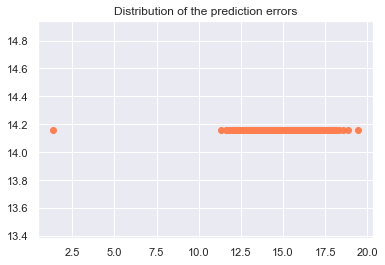

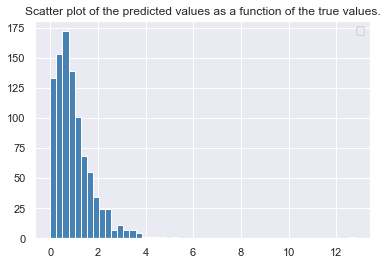

In [194]:
from sklearn import dummy

# 0) We create a dummy regressor model that always predicts the mean value of the feature to predict
dum = dummy.DummyRegressor(strategy='mean')

# 1) Training Dummy Regression
dum.fit(X_train, y_train)

# 2) Prediction on the testing set
y_pred_dum = dum.predict(X_test)

# 3) Evaluate
results = evaluate_regression("Dummy Regressor", results, y_test, y_pred_dum)

#### 2) baseline : Linear Regression

R2 : 0.7218117324385016
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


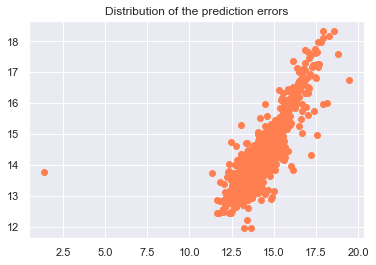

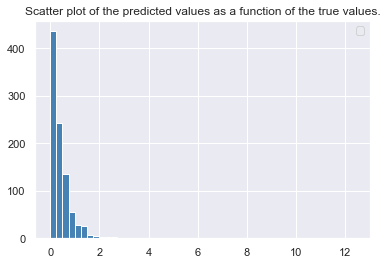

In [195]:
from sklearn import linear_model

# 0) We create a linear regression model
lr = linear_model.LinearRegression()

# 1) Training Linear Regression and Evaluating
reg = lr.fit(X_train, y_train)
y_pred_lr = reg.predict(X_test)

prediction_score = lr.score(X_test, y_test)
print('R2 : {}'.format(prediction_score))

results = evaluate_regression("Linear Regression", results, y_test, y_pred_lr)

In [196]:
baseline_error = mean_squared_error(y_test, y_pred_dum)
print("Baseline error = MSE from Dummy Regressor :", baseline_error)

Baseline error = MSE from Dummy Regressor : 1.7172277161096732


#### 2) Linear Model : Ridge

In [197]:
# Setting evaluation metric for regression
scoring = 'r2'

##### 2.1) Trying Ridge Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [198]:
a, b = -5, 3
n_alphas = 1000 # hyperparametre alpha
alphas = np.logspace(a, b, n_alphas)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    coefs.append(ridge.coef_)
    errors.append(np.mean((y_pred_ridge - y_test) ** 2))
    #print("HERE :", np.mean(( - y_test) ** 2), "MSE :", mean_squared_error(y_test, ridge.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for Ridge Regression : 0.4682412459193651
Best alpha for that minimal MSE :  2.893753019050953


(3.981071705534969e-06,
 2511.88643150958,
 0.40579192240984974,
 1.7796770396191885)

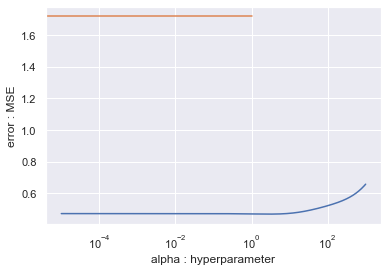

In [199]:
# recupere l'erreur min
print("Minimum Mean Squared Error for Ridge Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors, [baseline_error, baseline_error])
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(3.981071705534969e-06,
 2511.88643150958,
 -1.7886952295082128,
 1.5544274291570623)

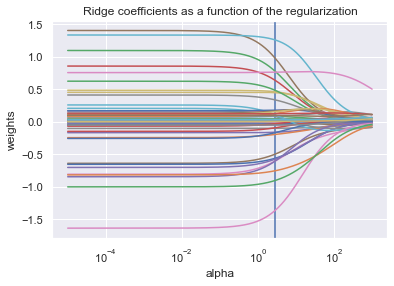

In [200]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  2.893753019050953
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.68428,0.46824,0.40743,0.28089,0.72701
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


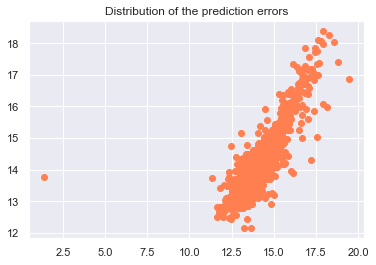

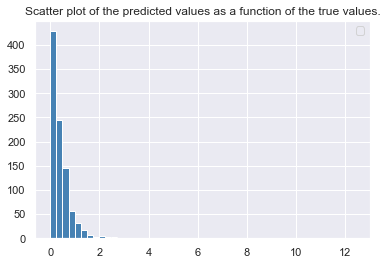

In [201]:
print("Getting y_pred for the best alpha : ", min_alpha)
ridge.set_params(alpha=min_alpha)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# 3) Evaluate
results = evaluate_regression("Ridge manually", results, y_test, y_pred_ridge)

##### 2.2) Optimization of hyperparameters

In [202]:
# define the model/ estimator
model = linear_model.Ridge()
params = {"alpha": np.logspace(a, b, n_alphas)} # alpha > 0

# define the grid search
Ridge_reg = GridSearchCV(
    model, params, scoring=scoring,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Ridge_reg.fit(X_train.values, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([            inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             i...
       9.16140246e+021, 9.20373200e+020, 9.24625712e+019, 9.28897872e+018,
       9.33189772e+017, 9.37501502e+016, 9.41833153e+015, 9.46184819e+014,
       9.50556592e+013, 9.54948564e+012, 9.59360829e+011, 9.63793480e+010,
       9.68246612e+009, 9.72720319e+008, 9.77214697e+007, 9.81729841e+006,
       9.86265846e+005, 9.90822810e+004, 9.95400829e+003, 1.00000000e+003])},
             return_train_score=True, scoring='r2', verbose=1)

Best estimator : Ridge(alpha=1000.0)
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.68428,0.46824,0.40743,0.28089,0.72701
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,Ridge GridSearchCV,0.81074,0.65730,0.52587,0.38236,0.61679
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


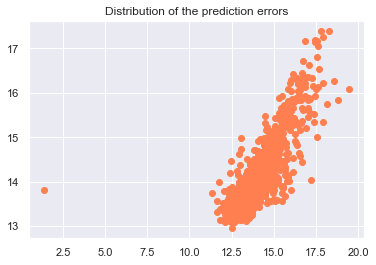

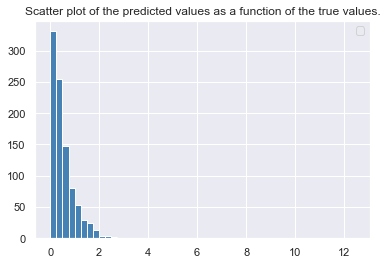

In [203]:
# best estimator
print("Best estimator :", Ridge_reg.best_estimator_)

# best model
best_model = Ridge_reg.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_ridge = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("Ridge GridSearchCV", results, y_test, y_pred_ridge)

In [204]:
print("QUESTION MENTOR : pourquoi optimisation alpha manuelle meilleure ??? ")

QUESTION MENTOR : pourquoi optimisation alpha manuelle meilleure ??? 


#### 3) Linear Model : LASSO

##### 3.1) Trying LASSO Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [205]:
n_alphas = 500  # hyperparametre alpha
a, b = -5, -2
alphas = np.logspace(a, b, n_alphas)

lasso = linear_model.Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    coefs.append(lasso.coef_)
    errors.append(np.mean((y_pred_lasso - y_test) ** 2))
    #print("HERE :", np.mean((lasso.predict(X_test) - y_test) ** 2), "MSE :", mean_squared_error(y_test, lasso.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for LASSO Regression : 0.4686801156683241
Best alpha for that minimal MSE :  0.0006540805914998259


(5.623413251903491e-06,
 1.7782794100389228,
 0.4062527356462567,
 1.7796550961317406)

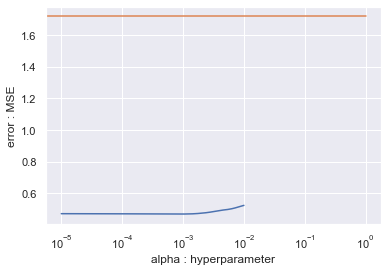

In [206]:
# recupere l'erreur min
print("Minimum Mean Squared Error for LASSO Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors, [baseline_error, baseline_error])
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(7.079457843841373e-06,
 0.01412537544622754,
 -1.9015843558920484,
 1.5067385274402754)

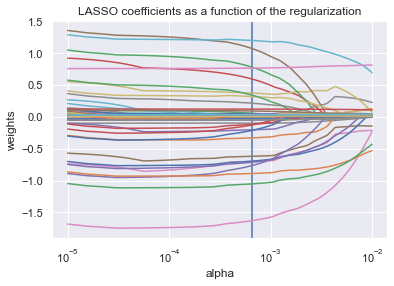

In [207]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  0.0006540805914998259
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.68428,0.46824,0.40743,0.28089,0.72701
0,LASSO manually,0.68460,0.46868,0.40675,0.27950,0.72675
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,Ridge GridSearchCV,0.81074,0.65730,0.52587,0.38236,0.61679
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


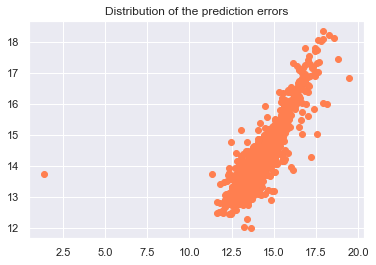

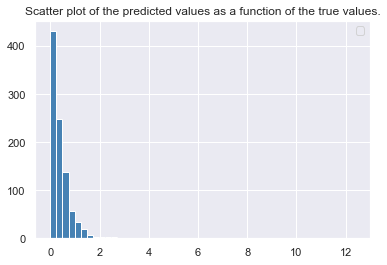

In [208]:
print("Getting y_pred for the best alpha : ", min_alpha)
lasso.set_params(alpha=min_alpha)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# 3) Evaluate
results = evaluate_regression("LASSO manually", results, y_test, y_pred_lasso)

In [209]:
y_pred_lasso

array([13.82254331, 15.294392  , 12.89305101, 15.03195897, 14.15583997,
       13.56637691, 15.16591736, 13.04597057, 14.71993712, 13.75290832,
       14.67244246, 14.76323036, 13.99504992, 14.07290445, 13.63175447,
       13.36543163, 13.27237541, 16.01634659, 14.97610589, 14.69237841,
       12.99047523, 13.30318307, 13.29217579, 13.11721467, 13.03335489,
       13.79153817, 14.64185599, 15.12938858, 13.04354887, 13.74399066,
       14.20917271, 15.06030785, 15.18822901, 13.28610219, 14.52773687,
       16.61509731, 14.23370562, 15.08832269, 13.69133264, 13.74679722,
       14.80042677, 14.32248751, 13.05790579, 14.18084558, 13.25223402,
       13.79647048, 14.62842519, 13.97717344, 14.23841383, 14.43164962,
       13.64914221, 13.11215387, 15.17424717, 13.81163334, 12.81533784,
       14.99958884, 13.74423443, 13.96805735, 14.59657429, 15.03515336,
       15.15898731, 13.00949274, 13.42018346, 13.0189857 , 15.93956149,
       13.03185663, 13.97729743, 12.95227875, 14.53587708, 13.09

##### 3.2) Optimization of hyperparameters

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best estimator : Lasso(alpha=0.001)
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.68428,0.46824,0.40743,0.28089,0.72701
0,LASSO manually,0.68460,0.46868,0.40675,0.27950,0.72675
0,LASSO GridSearchCV,0.68489,0.46908,0.40705,0.27707,0.72652
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,Ridge GridSearchCV,0.81074,0.65730,0.52587,0.38236,0.61679
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


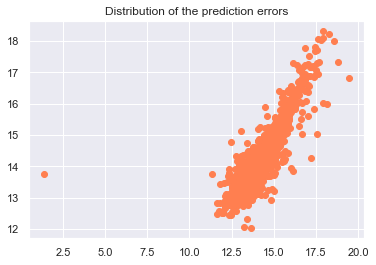

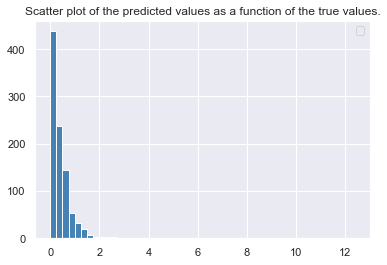

In [210]:
n_alphas = 50
a, b = -4, -3
params = {"alpha": np.logspace(a, b, n_alphas)}

# define the model/ estimator
model = linear_model.Lasso()

# define the grid search
Lasso_reg = GridSearchCV(
    model, params, scoring=scoring,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Lasso_reg.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", Lasso_reg.best_estimator_)

# best model
best_model = Lasso_reg.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_lasso = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("LASSO GridSearchCV", results, y_test, y_pred_lasso)

In [211]:
y_pred_lasso
print("ASK MENTOR : pk optimisation meilleure manuelle que avec griddeach ?????")

ASK MENTOR : pk optimisation meilleure manuelle que avec griddeach ?????


#### 4) Linear Model : Elastic Net

##### 4.1) Trying Elastic Net Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameters alpha and l1_ratio

In [212]:
n = 100
l1_ratio = np.random.uniform(0, 1, size=(1, 100))
l1_ratio

l = [i / n for i in range(n)]
l = np.arange(0, 1, 10**-2)

l1_ratio = np.arange(start=0, stop=1, step= 1/n)
l1_ratio

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

min_index = np.argmin(alphas)
min_alpha = alphas[min_index]
min_alpha

##### 4.2) Optimization of hyperparameters

In [213]:
scoring

'r2'

R2 : 0.7269592846220334 RMSE : 0.6843437328817591 Best params : {'l1_ratio': 0.14, 'alpha': 0.0017575106248547913}
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.68428,0.46824,0.40743,0.28089,0.72701
0,Elastic Net 1,0.68434,0.46833,0.40761,0.28063,0.72696
0,LASSO manually,0.68460,0.46868,0.40675,0.27950,0.72675
0,LASSO GridSearchCV,0.68489,0.46908,0.40705,0.27707,0.72652
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,Ridge GridSearchCV,0.81074,0.65730,0.52587,0.38236,0.61679
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


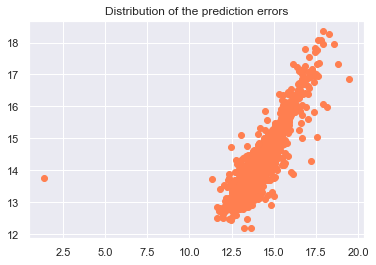

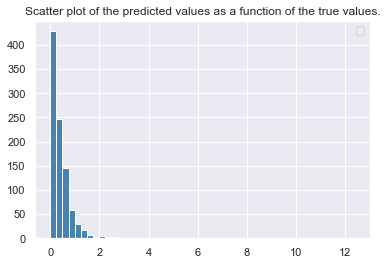

In [214]:
regressor = linear_model.ElasticNet()

# Define the cross-validation generator
cv_inner = KFold(
    n_splits=10, # number of folds (default=5)
    shuffle=True, # shuffle the data before splitting into batche
    random_state=seed, # seeding the random number generator for shuffling
)

a, b , n_alphas = -3, 3, 50
param_grid_elastic = [{
    "alpha": np.logspace(a, b, n_alphas), # penalty intensity (5 values between 10⁻³ and 10¹)
    "l1_ratio": l1_ratio # mixing parameter for l1 and l2 penalties
}]



# Intenciation of RandomizedSearchCV object
randomsearch = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_grid_elastic, # choice of hyper-parameters to test
    scoring=scoring, # scoring method for regression
    cv=cv_inner, # cross-validation generator
    n_jobs=-1, # use all available cores (parallelization)
    return_train_score=True, # to avoid a DeprecationWarning
    n_iter=10, # number of combinations of hyper-parameters to try
)


# Call the RanddomizedSearch with Cross Validation using the chosen regressor
randomsearch.fit(X_train, y_train)
# Results
y_pred_elastic = randomsearch.predict(X_test)
R2_score = randomsearch.score(X_test, y_test)
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print("R2 :", R2_score, "RMSE :", RMSE_score, "Best params :", randomsearch.best_params_)
results = evaluate_regression("Elastic Net 1", results, y_test, y_pred_elastic)

R2 : 0.7268957544771842 RMSE : 0.6844233435869312 Best params : {'l1_ratio': 0.5, 'alpha': 0.0013257113655901094}
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.68428,0.46824,0.40743,0.28089,0.72701
0,Elastic Net 1,0.68434,0.46833,0.40761,0.28063,0.72696
0,Elastic Net 2,0.68442,0.46844,0.40722,0.27743,0.72690
0,LASSO manually,0.68460,0.46868,0.40675,0.27950,0.72675
0,LASSO GridSearchCV,0.68489,0.46908,0.40705,0.27707,0.72652
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,Ridge GridSearchCV,0.81074,0.65730,0.52587,0.38236,0.61679
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


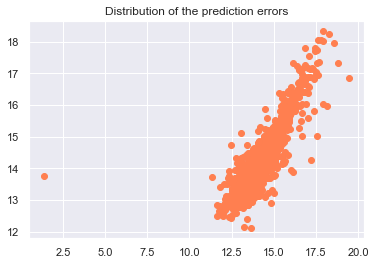

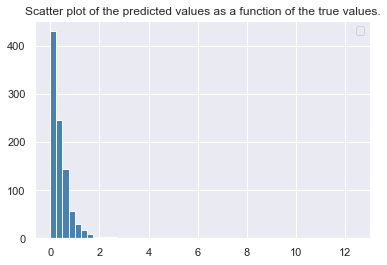

In [215]:
rs_cv= RandomizedSearchCV(estimator=regressor,
                          param_distributions=param_grid_elastic,
                          n_iter = 100,
                          scoring=scoring,
                          cv=5,
                          verbose=0,
                          refit=True,
                          n_jobs=-1,
                          return_train_score=True)
rs_cv.fit(X_train, y_train)

# Results
y_pred_elastic = rs_cv.predict(X_test)
R2_score = rs_cv.score(X_test, y_test)
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print("R2 :", R2_score, "RMSE :", RMSE_score, "Best params :", rs_cv.best_params_)
#print("Train score :", rs_cv.cv_results_["mean_train_score"])

results = evaluate_regression("Elastic Net 2", results, y_test, y_pred_elastic)

### 2) Ensemble learning methods

#### 1) Parallelized Implementation : Random Forest

In [216]:
# Grid of research for Random Forest
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint

regressor = RandomForestRegressor(n_jobs=-1, random_state=seed, n_estimators=1000)

# Create space of candidate values for hyperparameters
param_grid_forest = [{
    "max_features": [i for i in range(2, 8)], # number of features to consider at each node
    "max_depth": [i for i in range(2, 10)], # maximum depth (to prune) a stump
    "min_samples_leaf": [i for i in range(2, 10)], # minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [i for i in range(50, 1000, 100)]
}]

# Intenciation of RandomizedSearchCV object
randomsearch = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_grid_forest, # choice of hyper-parameters to test
    scoring=scoring, # scoring method for regression
    cv=cv_inner, # cross-validation generator
    n_jobs=-1, # use all available cores (parallelization)
    return_train_score=True, # to avoid a DeprecationWarning
)


# Call the RanddomizedSearch with Cross Validation using the chosen regressor
randomsearch.fit(X_train, y_train)
# Results
y_pred_rfr = randomsearch.predict(X_test)
R2_score = randomsearch.score(X_test, y_test)
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred_rfr))

print("R2 :", R2_score, "RMSE :", RMSE_score, "Best params :", randomsearch.best_params_)

R2 : 0.6675604151821836 RMSE : 0.755121704613351 Best params : {'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 7, 'max_depth': 9, 'bootstrap': False}


Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.68428,0.46824,0.40743,0.28089,0.72701
0,Elastic Net 1,0.68434,0.46833,0.40761,0.28063,0.72696
0,Elastic Net 2,0.68442,0.46844,0.40722,0.27743,0.72690
0,LASSO manually,0.68460,0.46868,0.40675,0.27950,0.72675
0,LASSO GridSearchCV,0.68489,0.46908,0.40705,0.27707,0.72652
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,Random Forest,0.75512,0.57021,0.46668,0.31210,0.66756
0,Ridge GridSearchCV,0.81074,0.65730,0.52587,0.38236,0.61679
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


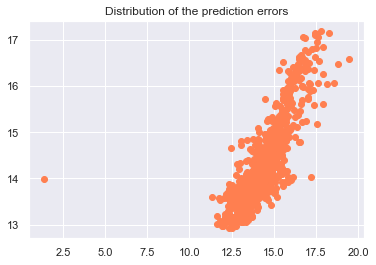

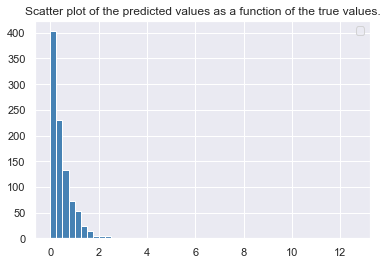

In [217]:
results = evaluate_regression("Random Forest", results, y_test, y_pred_rfr)

In [218]:
# 1) GridSearchCV or RandomizedSearchCV

#### 2) Sequential method : XGBoost

GridSearchCV XGBoost Regressor
Best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0.2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Prediction for :  Log-Electricity(kBtu)


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.68428,0.46824,0.40743,0.28089,0.72701
0,Elastic Net 1,0.68434,0.46833,0.40761,0.28063,0.72696
0,Elastic Net 2,0.68442,0.46844,0.40722,0.27743,0.72690
0,LASSO manually,0.68460,0.46868,0.40675,0.27950,0.72675
0,LASSO GridSearchCV,0.68489,0.46908,0.40705,0.27707,0.72652
0,Linear Regression,0.69076,0.47716,0.41038,0.28151,0.72181
0,XGBoost GridSearchCV,0.69163,0.47835,0.40764,0.27851,0.72111
0,Random Forest,0.75512,0.57021,0.46668,0.31210,0.66756
0,Ridge GridSearchCV,0.81074,0.65730,0.52587,0.38236,0.61679
0,Dummy Regressor,1.31043,1.71723,0.98920,0.78971,-0.00117


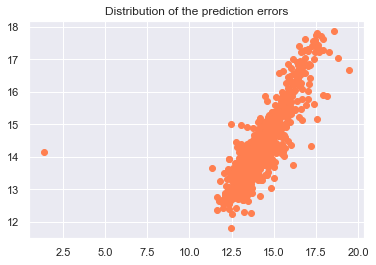

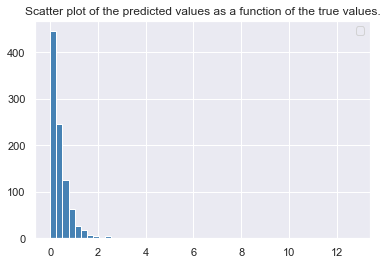

In [219]:
print("GridSearchCV XGBoost Regressor")

from xgboost import XGBRegressor

gsc = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={"learning_rate": (0.05, 0.10, 0.15),
                "max_depth": [ 3, 4, 5, 6, 8],
                "min_child_weight": [ 1, 3, 5, 7],
                "gamma":[ 0.0, 0.1, 0.2],
                "colsample_bytree":[ 0.3, 0.4],},
    cv=5, scoring=scoring, verbose=0, n_jobs=-1)

#fit the grid search
gsc.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", gsc.best_estimator_)

# best model
best_model = gsc.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_xgbr = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("XGBoost GridSearchCV", results, y_test, y_pred_xgbr)


### III) Evaluation

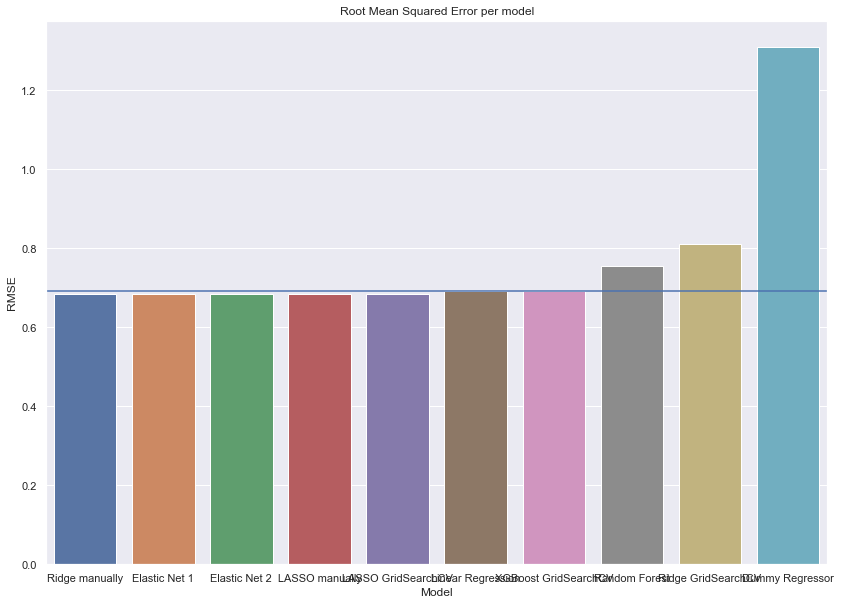

In [220]:
display_barplot_errors(results, baseline_model="Linear Regression", title="Root Mean Squared Error per model", metric="RMSE")

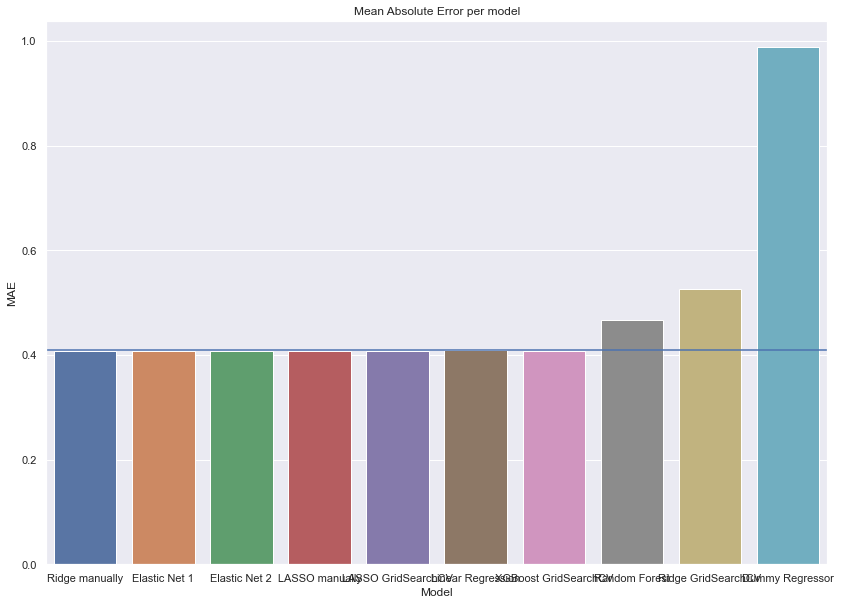

In [221]:
display_barplot_errors(results, baseline_model="Linear Regression", title="Mean Absolute Error per model", metric="MAE")

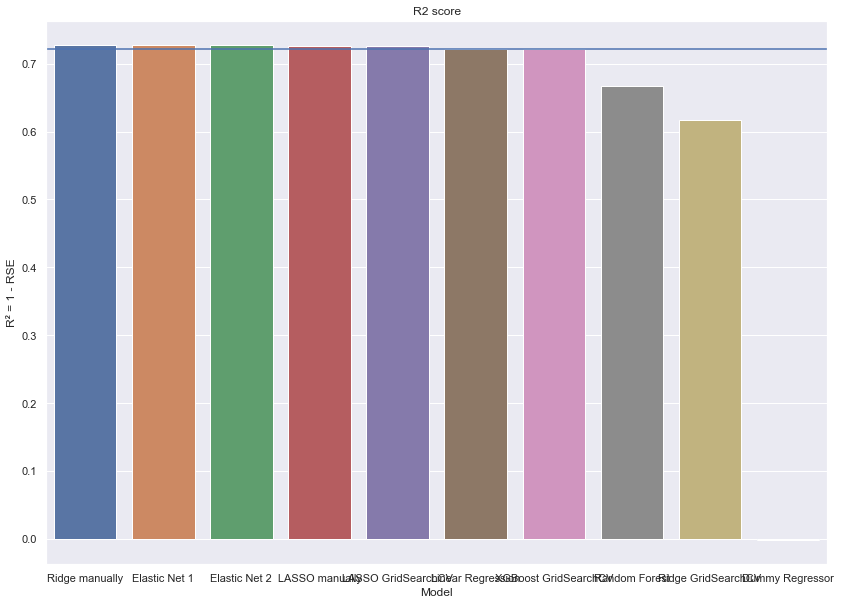

In [222]:
display_barplot_errors(results, baseline_model="Linear Regression", title="R2 score", metric="R² = 1 - RSE")